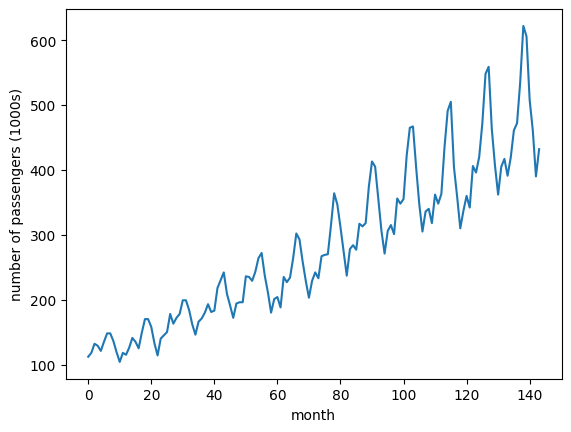

In [244]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import blocks
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

##use this only if you didn't download yet the csv file##
##!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

training_set = pd.read_csv('airline-passengers.csv')

training_set = training_set.iloc[:,1:2].values

plt.xlabel('month')
plt.ylabel('number of passengers (1000s)')
plt.plot(training_set)
plt.show()

In [245]:
sc = MinMaxScaler()
data = sc.fit_transform(training_set)

test_size=36
training_data=data[:len(data)-test_size]

print("train-set samples: ",training_data.size)
print("num features: ",training_data.shape[1])

train-set samples:  108
num features:  1


In [246]:
def moment_loss(fake_data, real_data):
    fake_mean = fake_data.mean()
    real_mean = real_data.mean()
    fake_std = fake_data.std()
    real_std = real_data.std()
    return abs(fake_mean - real_mean) + abs(fake_std - real_std)

In [247]:
import os
path = "models"
# Check whether the specified path exists or not
isExist = os.path.exists(path)
if not isExist:
   # Create a new directory because it does not exist
   os.makedirs(path)
   print("The new models directory is created!")

In [248]:
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam

#Hyperparameters
discriminator_lr = 0.01
generator_lr = 0.01
num_epochs = 3
embedding_dim = 10
batch = 10
seq_length = 8
num_features = training_data.shape[1]
criterion = nn.MSELoss()

#Initializations
#train_set = TensorDataset(trainX, trainY)
#train_loader = DataLoader(train_set, batch=trainX.size(0), shuffle=True) 


G = blocks.Generator(embedding_dim, seq_length, num_features)
G.addBlock()
optimG = Adam(G.parameters(), lr=generator_lr, betas=(0.9, 0.999))
#D = blocks.Discriminator()
#optimD = Adam(D.parameters(), lr=discriminator_lr, betas=(0.9, 0.999))


#Training
g_losses = []
d_losses = []
g_loss_min=1000000
for epoch in range(num_epochs):
        # Generate fake data
        fake_data = G(training_data,batch,epoch)
        #fake_label = torch.zeros(Y.size(0))
        '''
        # Train the discriminator
        D.zero_grad()
        d_real_loss = criterion(D(X), torch.ones_like(D(X)))
        d_fake_loss = criterion(D(fake_data.detach()), torch.zeros_like(D(fake_data.detach())))
        d_loss = d_real_loss + d_fake_loss
        d_losses.append(d_loss.item())
        d_loss.backward()
        optimD.step()
        '''
        # Train the generator
        G.zero_grad()
        #g_loss = criterion(D(fake_data), torch.ones_like(D(fake_data)))
        # Add the moment loss
        #g_loss += moment_loss(fake_data, X)
        g_loss = moment_loss(fake_data, training_data[:batch])
        g_losses.append(g_loss.item())
        if(g_loss<g_loss_min):
            g_loss_min = g_loss
            torch.save(G.state_dict(), 'models/generator.pt')
            torch.save(G, 'models/generator_model.pt')
            print('Improvement-Detected, save-model')
        g_loss.backward()
        optimG.step()
        
        # Print the losses
        if (epoch+1) % 1 == 0:
            #print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % 
                #(epoch+1, num_epochs, i+1, len(train_loader), d_loss.item(), g_loss.item()))
            print("[Epoch %d/%d] [Batch %d/%d] [G loss: %f]" % 
                (epoch+1, num_epochs, batch, len(training_data)/batch, g_loss.item()))
           




kernel_size:  1
Improvement-Detected, save-model
[Epoch 1/3] [Batch 10/10] [G loss: 0.933013]
Improvement-Detected, save-model
[Epoch 2/3] [Batch 10/10] [G loss: 0.834693]
Improvement-Detected, save-model
[Epoch 3/3] [Batch 10/10] [G loss: 0.568361]


In [249]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_training_history(name, discriminator_loss, generator_loss):
  #print('Train_acc: ',train_acc)
  #print('Train_loss: ',train_loss)
  #device = torch.device("cpu")
  fig, ax1 = plt.subplots(figsize=(20, 6))

  ax1.plot(discriminator_loss, 'o-', label='discriminator loss')
  ax1.plot(generator_loss, '^-', label='generator loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  fig.suptitle(f'Training history {name}')
  print("End-training Generator Loss:",generator_loss[-1])
  print("End-training Discriminator Loss:",discriminator_loss)

End-training Generator Loss: 0.5683612823486328
End-training Discriminator Loss: []


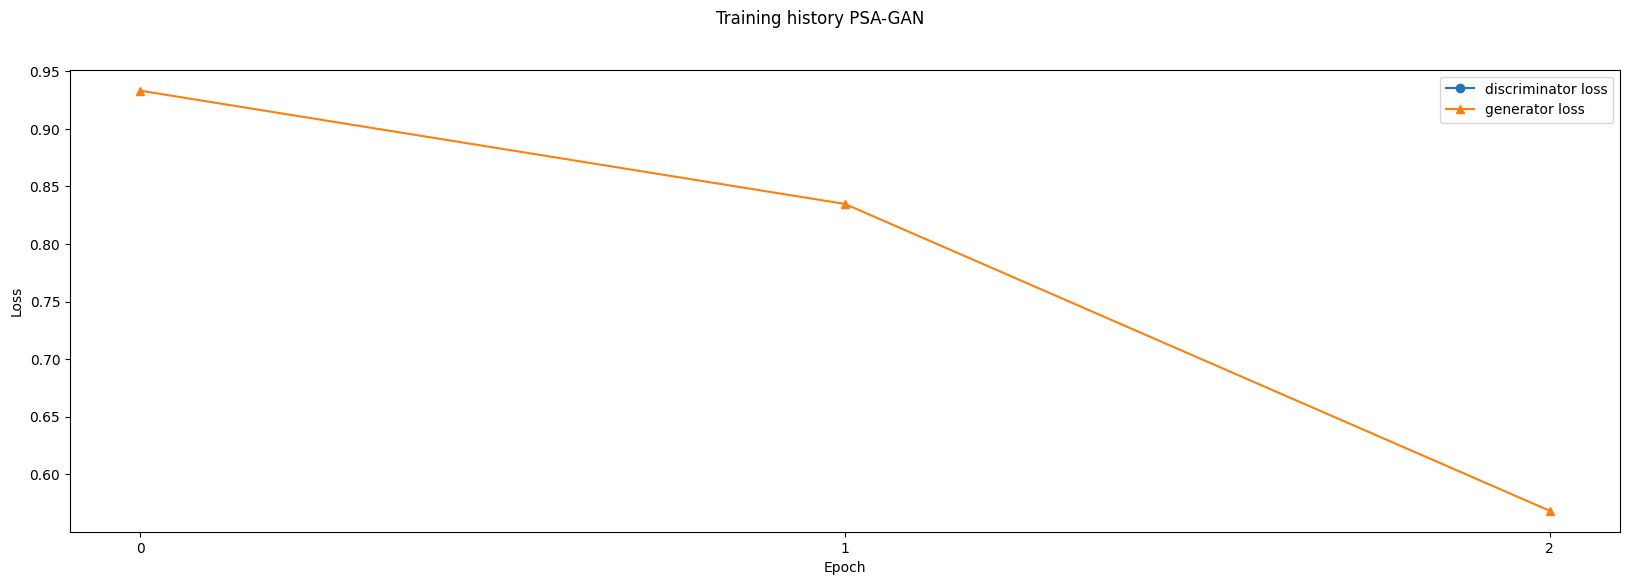

In [250]:
plot_training_history('PSA-GAN',d_losses, g_losses)

In [251]:
# Use the trained generator to generate new time series samples
with torch.no_grad():    
    generated_series = G(data,1,len(data)-test_size-seq_length)
    print("generated_series: ",generated_series.shape)

generated_series:  torch.Size([1, 32])


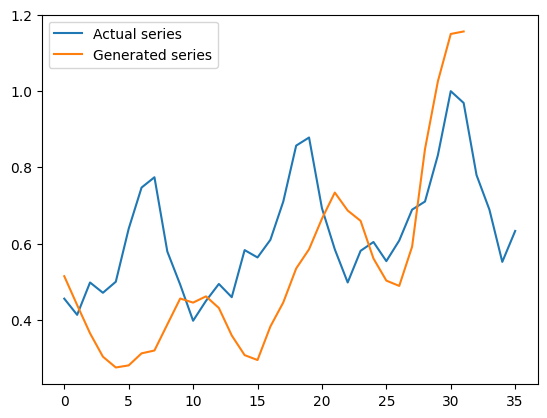

In [252]:
# Plot the generated time series samples
plt.figure()
plt.plot(data[-test_size:], label='Actual series')
plt.plot(generated_series[0], label='Generated series')
plt.legend()
plt.show()